In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
!pip install sentencepiece
!pip install nlpaug
!pip install transformers
import nlpaug.augmenter.word as naw
from nlpaug.util import Action
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

from torch.nn.utils import clip_grad_norm_

In [ ]:
!pip install torch
!pip install transformers
import pandas as pd
import nlpaug.augmenter.word as naw
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import  BertTokenizer, BertForSequenceClassification

from transformers import get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import CrossEntropyLoss
from transformers import AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<ipython-input-5-b8b4f1ae5ebe>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
<ipython-input-5-b8b4f1ae5ebe>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(train_encodings['attention_mask']),
<ipython-input-5-b8b4f1ae5ebe>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
<ipython-input-5-b8b4f1ae5ebe>:25: UserWarning: To copy construct from a tensor, it is recommended to use 

Epoch 1/20 - Train Loss: 2.7636 - Train Accuracy: 0.3735
Epoch 1/20 - Test Loss: 1.2680 - Test Accuracy: 0.7210
Epoch 2/20 - Train Loss: 0.9514 - Train Accuracy: 0.7574
Epoch 2/20 - Test Loss: 0.7583 - Test Accuracy: 0.7777
Epoch 3/20 - Train Loss: 0.6678 - Train Accuracy: 0.7906
Epoch 3/20 - Test Loss: 0.6456 - Test Accuracy: 0.7886
Epoch 4/20 - Train Loss: 0.5609 - Train Accuracy: 0.8056
Epoch 4/20 - Test Loss: 0.6128 - Test Accuracy: 0.7933
Epoch 5/20 - Train Loss: 0.4953 - Train Accuracy: 0.8173
Epoch 5/20 - Test Loss: 0.6101 - Test Accuracy: 0.7846
Epoch 6/20 - Train Loss: 0.4393 - Train Accuracy: 0.8336
Epoch 6/20 - Test Loss: 0.6277 - Test Accuracy: 0.7716
Epoch 7/20 - Train Loss: 0.3900 - Train Accuracy: 0.8459
Epoch 7/20 - Test Loss: 0.6545 - Test Accuracy: 0.7680
Epoch 8/20 - Train Loss: 0.3464 - Train Accuracy: 0.8610
Epoch 8/20 - Test Loss: 0.6951 - Test Accuracy: 0.7636
Epoch 9/20 - Train Loss: 0.3051 - Train Accuracy: 0.8753
Epoch 9/20 - Test Loss: 0.7341 - Test Accuracy:

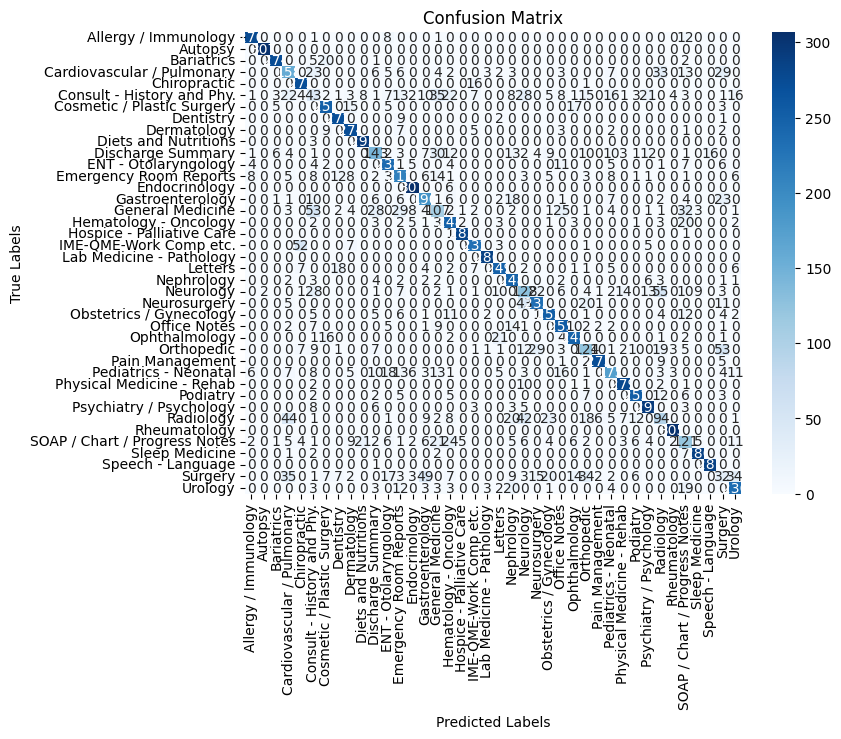

In [ ]:

# Step 1: Prepare the data
data = pd.read_csv('/content/drive/MyDrive/NLP_PROJECT/BALANCED_DATA/balanced_data.csv')
data = data.dropna()
X = data['description']
y = data['label']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Fine-tune the Bert model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(data['label'].unique()))
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


# Tokenize the input data
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=512, return_tensors='pt')
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=512, return_tensors='pt')
# Convert the input data to tensors
train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                             torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                             torch.tensor(test_encodings['attention_mask']),
                             torch.tensor(y_test))

# Define batch size and create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

#Define optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = CrossEntropyLoss()

# Fine-tune the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
num_epochs = 20


train_accuracy_list = []
train_loss_list = []
test_loss_list = []
test_accuracy_list  = []
epoch_list = []  # List of epochs from 1 to 20

# Learning rate scheduler
total_steps = len(train_loader) * num_epochs
warmup_steps = int(0.1 * total_steps) #warmup for the first tex of total steps

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = warmup_steps, num_training_steps = total_steps)

# Initialize variables for early stopping
best_test_accuracy = 0.0
patience = 5
no_improvement_count = 0



tokenizer.save_pretrained('/content/drive/MyDrive/NLP_PROJECT/BERT_TOKENIZER')


for epoch in range(num_epochs):
    epoch_list.append(epoch+1)
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, predicted_labels = torch.max(logits, 1)
        train_correct += (predicted_labels == labels).sum().item()
        train_total += labels.size(0)

        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

    train_accuracy = train_correct / train_total
    train_loss = train_loss / len(train_loader)
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)

    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f}")
    # After training loop
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0



    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, predicted_labels = torch.max(logits, 1)
            test_correct += (predicted_labels == labels).sum().item()
            test_total += labels.size(0)

            test_loss += loss.item()

    test_accuracy = test_correct / test_total
    test_loss = test_loss / len(test_loader)
    test_accuracy_list.append(test_accuracy)
    test_loss_list.append(test_loss)
    print(f"Epoch {epoch + 1}/{num_epochs} - Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}")
   # Save the model weights and optimizer state dictionary
    model_path = f'/content/drive/MyDrive/NLP_PROJECT/BERT_WEIGHTS/model_epoch_{epoch + 1}.pt'
    torch.save(model.state_dict(), model_path)


    # Check for early stopping condition
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        no_improvement_count = 0
        # Save the model weights and optimizer state dictionary for the best accuracy
        model_path = f'/content/drive/MyDrive/NLP_PROJECT/BERT_WEIGHTS/best_model.pt'
        torch.save(model.state_dict(), model_path)
    else:
        no_improvement_count += 1
        if no_improvement_count >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

# Calculate precision, recall, and F1 score
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits

        _, predicted_labels = torch.max(logits, 1)
        all_predictions.extend(predicted_labels.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate precision, recall, and F1 score
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Plot confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()





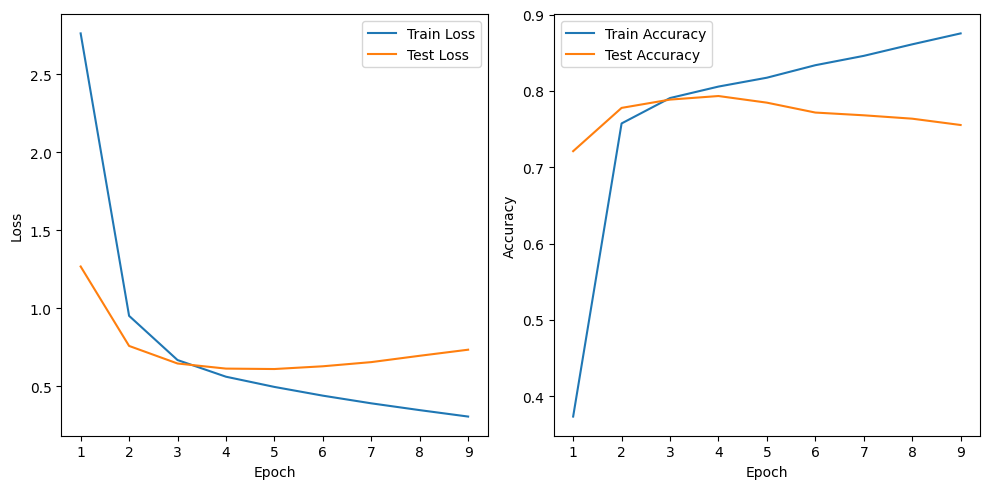

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_list, train_loss_list, label='Train Loss')
plt.plot(epoch_list, test_loss_list, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_list, train_accuracy_list, label='Train Accuracy')
plt.plot(epoch_list, test_accuracy_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()

# Save the plots to a specific directory
plots_dir = '/content/drive/MyDrive/NLP_PROJECT/PLOTS'
os.makedirs(plots_dir, exist_ok=True)
plt.savefig(os.path.join(plots_dir, 'bert_loss_and_accuracy_curves.png'))
plt.show()

In [ ]:
# to calculate the prediction time and trainig time
total_test_samples = len(X_test)
print(f"Total Test Samples: {total_test_samples}")

Total Test Samples: 11962


In [21]:
# Training time from the provided log
epoch_train_times = [
    # total 9 epochs time interval taken from saved each model weights in drive
    # estimated time interval to calculate after the log generated
    1500, 1140, 1140, 1380, 1200, 1140, 1800, 1440, 1140
]

# Sum of all epoch training times to get the total training time
total_training_time = sum(epoch_train_times)
print(f"Total Training Time: {total_training_time:.2f} seconds")

# Test set size and test accuracy from the provided log
total_test_samples =  11962 # total test accuracy
test_accuracy = 0.7553     # total test accuracy

# Estimate the prediction time
time_per_sample = total_training_time / len(epoch_train_times)  # Average time per training epoch
total_predicted_samples = total_test_samples * test_accuracy    # Estimated number of correctly predicted samples
prediction_time = time_per_sample * total_predicted_samples
print(f"Total Prediction Time: {prediction_time:.2f} seconds")

Total Training Time: 11880.00 seconds
Total Prediction Time: 11926066.15 seconds
